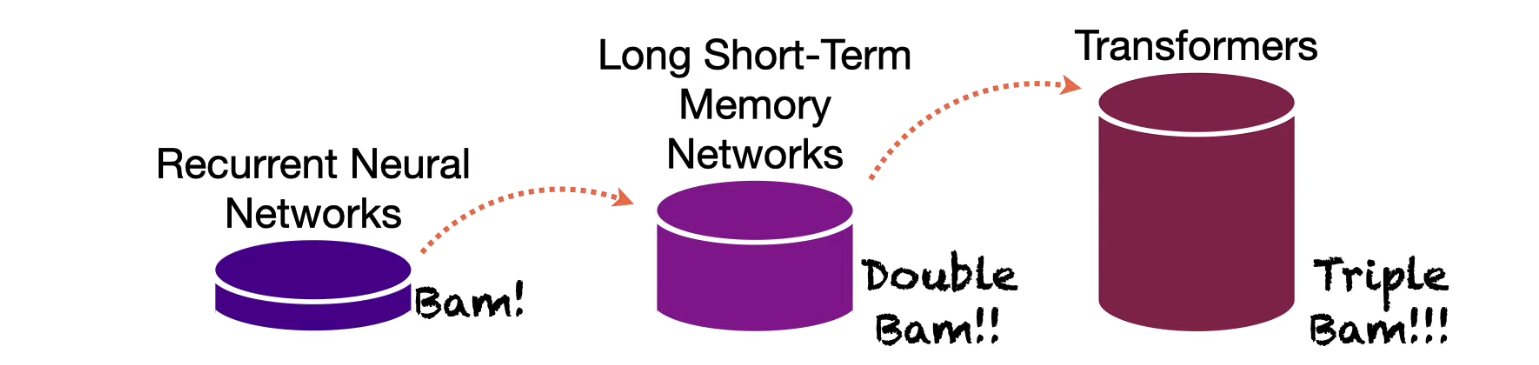

## Recurrent Neural Networks (RNNs) & Long Short-Term Memory (LSTM) 


#### An implementaion of [Recurrent Neural Networks (RNNs), Clearly Explained!!!](https://www.youtube.com/watch?v=AsNTP8Kwu80&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1&index=15)
#### Also an implementaion of [Long Short-Term Memory (LSTM), Clearly Explained](https://www.youtube.com/watch?v=YCzL96nL7j0&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1&index=16)

**The end goal of this markdown is to go to the depth of how an transformer works. For this we split the task into 3 parts**
* Recurrent Neural Networks
* Long short-term memory (LSTM)
* transformers

i found this article to be great: https://github.com/christianversloot/machine-learning-articles/blob/main/a-gentle-introduction-to-long-short-term-memory-networks-lstm.md

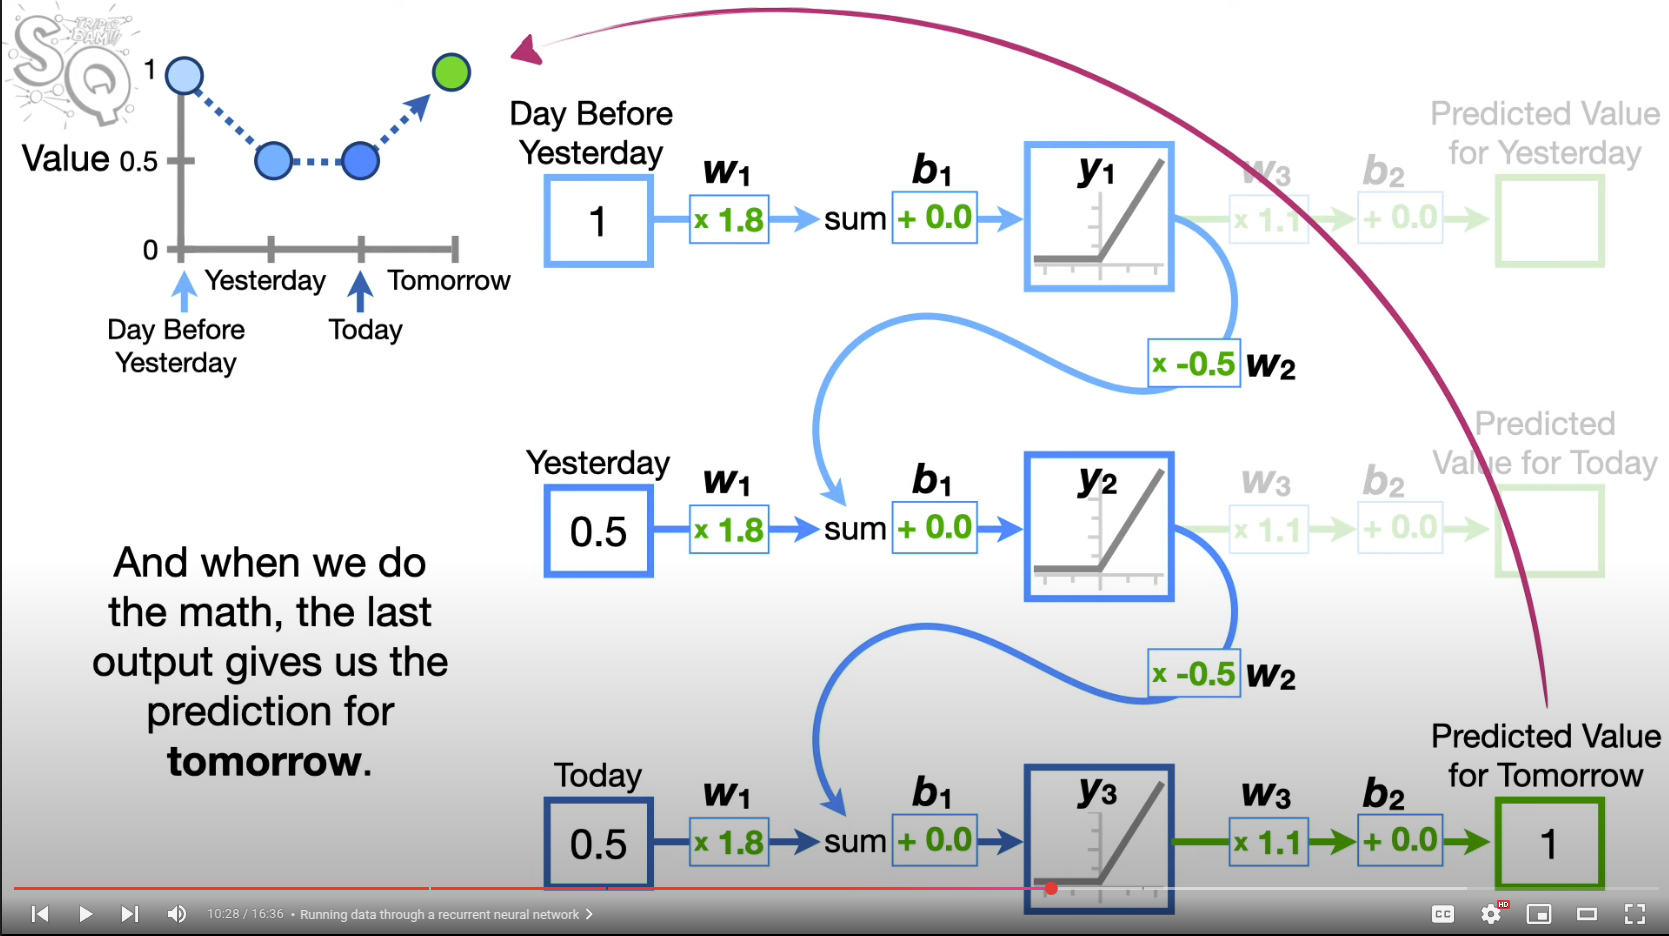

In [9]:
def simple_rnn_unroll(inputs, w1=1.8, w2=-0.5, b1=0.0, w3=1.1, b2=0.01):
    """
    Unrolls a single-neuron RNN over a sequence of inputs.
    """
    y_prev = 0.0      # Start with zero “previous activation”
    activations = []
    outputs = []
    
    for x in inputs:
        # Compute sum = w1*x + w2*y_prev + b1
        sum_t = w1 * x + w2 * y_prev + b1
        
        # Linear activation: y_t = sum_t
        y_t = sum_t
        
        # I tried to make a ReLU activation function here.
        out_t = max(0, w3 * y_t + b2)
        
        # Store the activation and output for this timestep
        activations.append(y_t)
        outputs.append(out_t)
        
        # Feedback for next timestep
        print(f"Input: {x:.2f}, Sum: {sum_t:.2f}, Activation: {y_t:.2f}, Output: {out_t:.2f}, Prev: {y_prev:.2f}")
        
        y_prev = y_t
        print(f"New y-prev: {y_prev:.2f}")
    
    return activations, outputs


if __name__ == "__main__":
    # Input
    daily_inputs = [1, 0.5, 0.5]

    y_vals, out_vals = simple_rnn_unroll(daily_inputs)

    # The last output for tomorrow's prediction
    print(f"\nPredicted value for Tomorrow = {out_vals[-1]:.4f}")


Input: 1.00, Sum: 1.80, Activation: 1.80, Output: 1.99, Prev: 0.00
New y-prev: 1.80
Input: 0.50, Sum: 0.00, Activation: 0.00, Output: 0.01, Prev: 1.80
New y-prev: 0.00
Input: 0.50, Sum: 0.90, Activation: 0.90, Output: 1.00, Prev: 0.00
New y-prev: 0.90

Predicted value for Tomorrow = 1.0000


## The Vanishin/Exploding Gradients problem

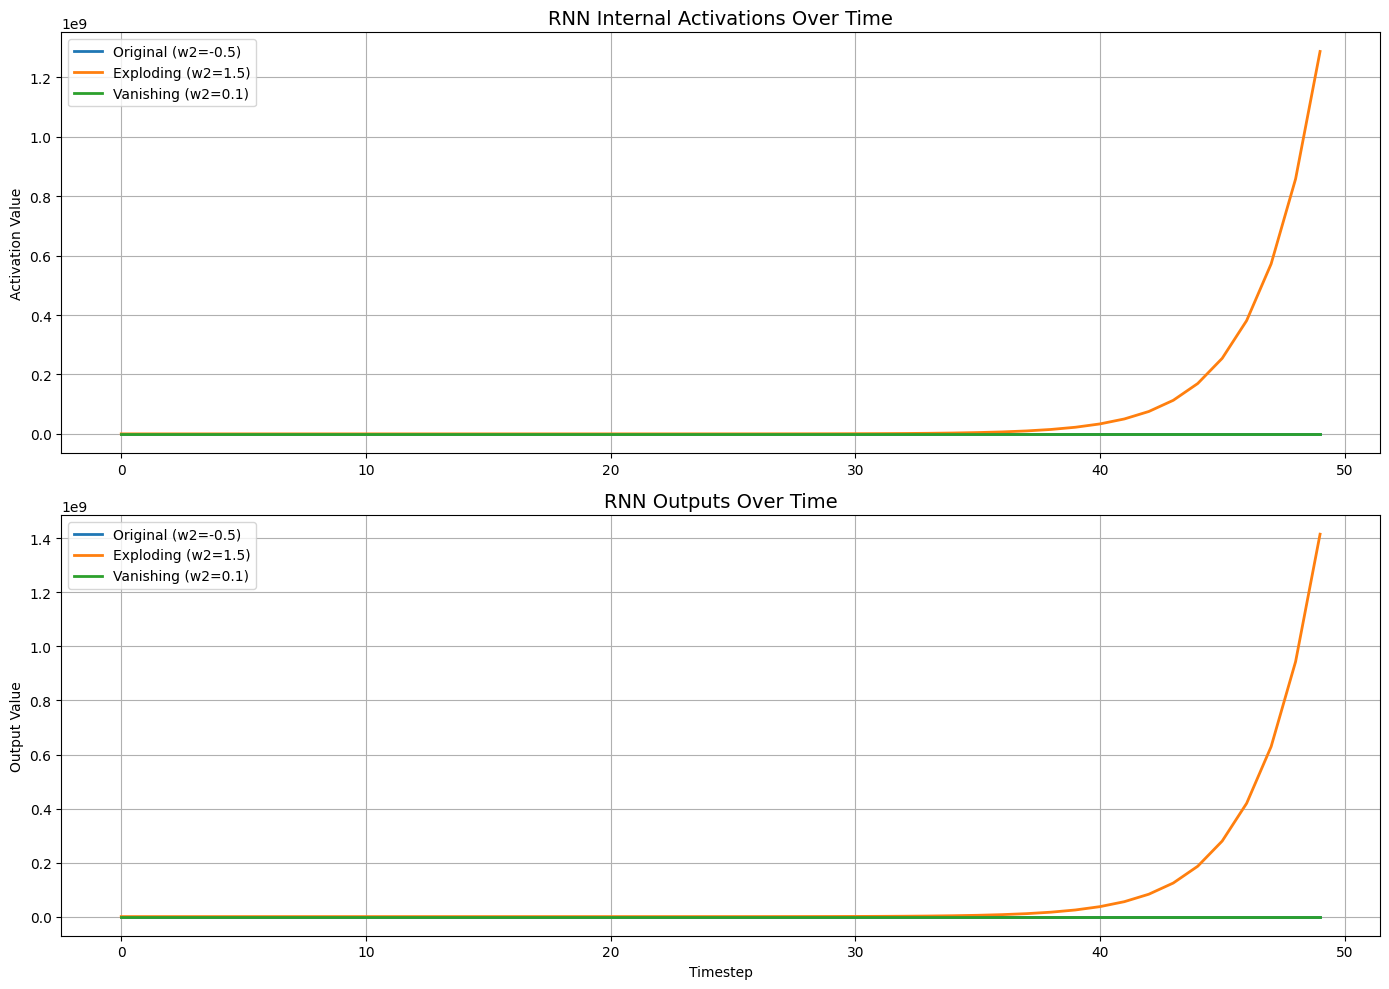

=== Activation Analysis ===

Original weights:
Min ratio: 0.0593
Max ratio: 26.0892
Mean ratio: 2.3910
Final activation value: 9.2924e-02

Exploding weights:
Min ratio: 1.5000
Max ratio: 4.0384
Mean ratio: 1.5691
Final activation value: 1.2870e+09

Vanishing weights:
Min ratio: 0.1265
Max ratio: 11.5083
Mean ratio: 1.9294
Final activation value: 4.4119e-01


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib
import os
# Generate 50 random inputs between 0 and 1 for demonstration
np.random.seed(42)  # For reproducibility
inputs_50 = np.random.uniform(0, 1, 50).tolist()

# Run the RNN for 50 timesteps with different recurrent weights to show the effect

with contextlib.redirect_stdout(open(os.devnull, 'w')):
    # Original weight w2=-0.5
    activations_original, outputs_original = simple_rnn_unroll(inputs_50)
    # Exploding gradient scenario with w2=1.5
    activations_exploding, outputs_exploding = simple_rnn_unroll(inputs_50, w2=1.5)
    # Vanishing gradient scenario with w2=0.1
    activations_vanishing, outputs_vanishing = simple_rnn_unroll(inputs_50, w2=0.1)

# Plot to visualize the problem
plt.figure(figsize=(14, 10))

# Activation values
plt.subplot(2, 1, 1)
plt.plot(activations_original, label='Original (w2=-0.5)', linewidth=2)
plt.plot(activations_exploding, label='Exploding (w2=1.5)', linewidth=2)
plt.plot(activations_vanishing, label='Vanishing (w2=0.1)', linewidth=2)
plt.title('RNN Internal Activations Over Time', fontsize=14)
plt.ylabel('Activation Value')
plt.grid(True)
plt.legend()

# Output values
plt.subplot(2, 1, 2)
plt.plot(outputs_original, label='Original (w2=-0.5)', linewidth=2)
plt.plot(outputs_exploding, label='Exploding (w2=1.5)', linewidth=2)
plt.plot(outputs_vanishing, label='Vanishing (w2=0.1)', linewidth=2)
plt.title('RNN Outputs Over Time', fontsize=14)
plt.xlabel('Timestep')
plt.ylabel('Output Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate growth or decay rates
print("=== Activation Analysis ===")
for name, activations in [("Original", activations_original), 
                        ("Exploding", activations_exploding), 
                        ("Vanishing", activations_vanishing)]:
    ratios = [abs(activations[i] / activations[i-1]) if abs(activations[i-1]) > 1e-10 else 0 
              for i in range(1, len(activations))]
    print(f"\n{name} weights:")
    print(f"Min ratio: {min([r for r in ratios if r > 0]):.4f}")
    print(f"Max ratio: {max(ratios):.4f}")
    print(f"Mean ratio: {np.mean([r for r in ratios if r > 0]):.4f}")
    print(f"Final activation value: {activations[-1]:.4e}")


## LSTM
To fix the error of The Vanishin/Exploding Gradients problem we will use LSTM


### Breakdown of what everything means


* Green line represents the longterm memory and is called the Cell State
* The Pink line is the short term memory and is connected to weights
* The orange line is Tanh Activation -1 and 1
* The Blue line is Sigmoid Activation 0 and 1

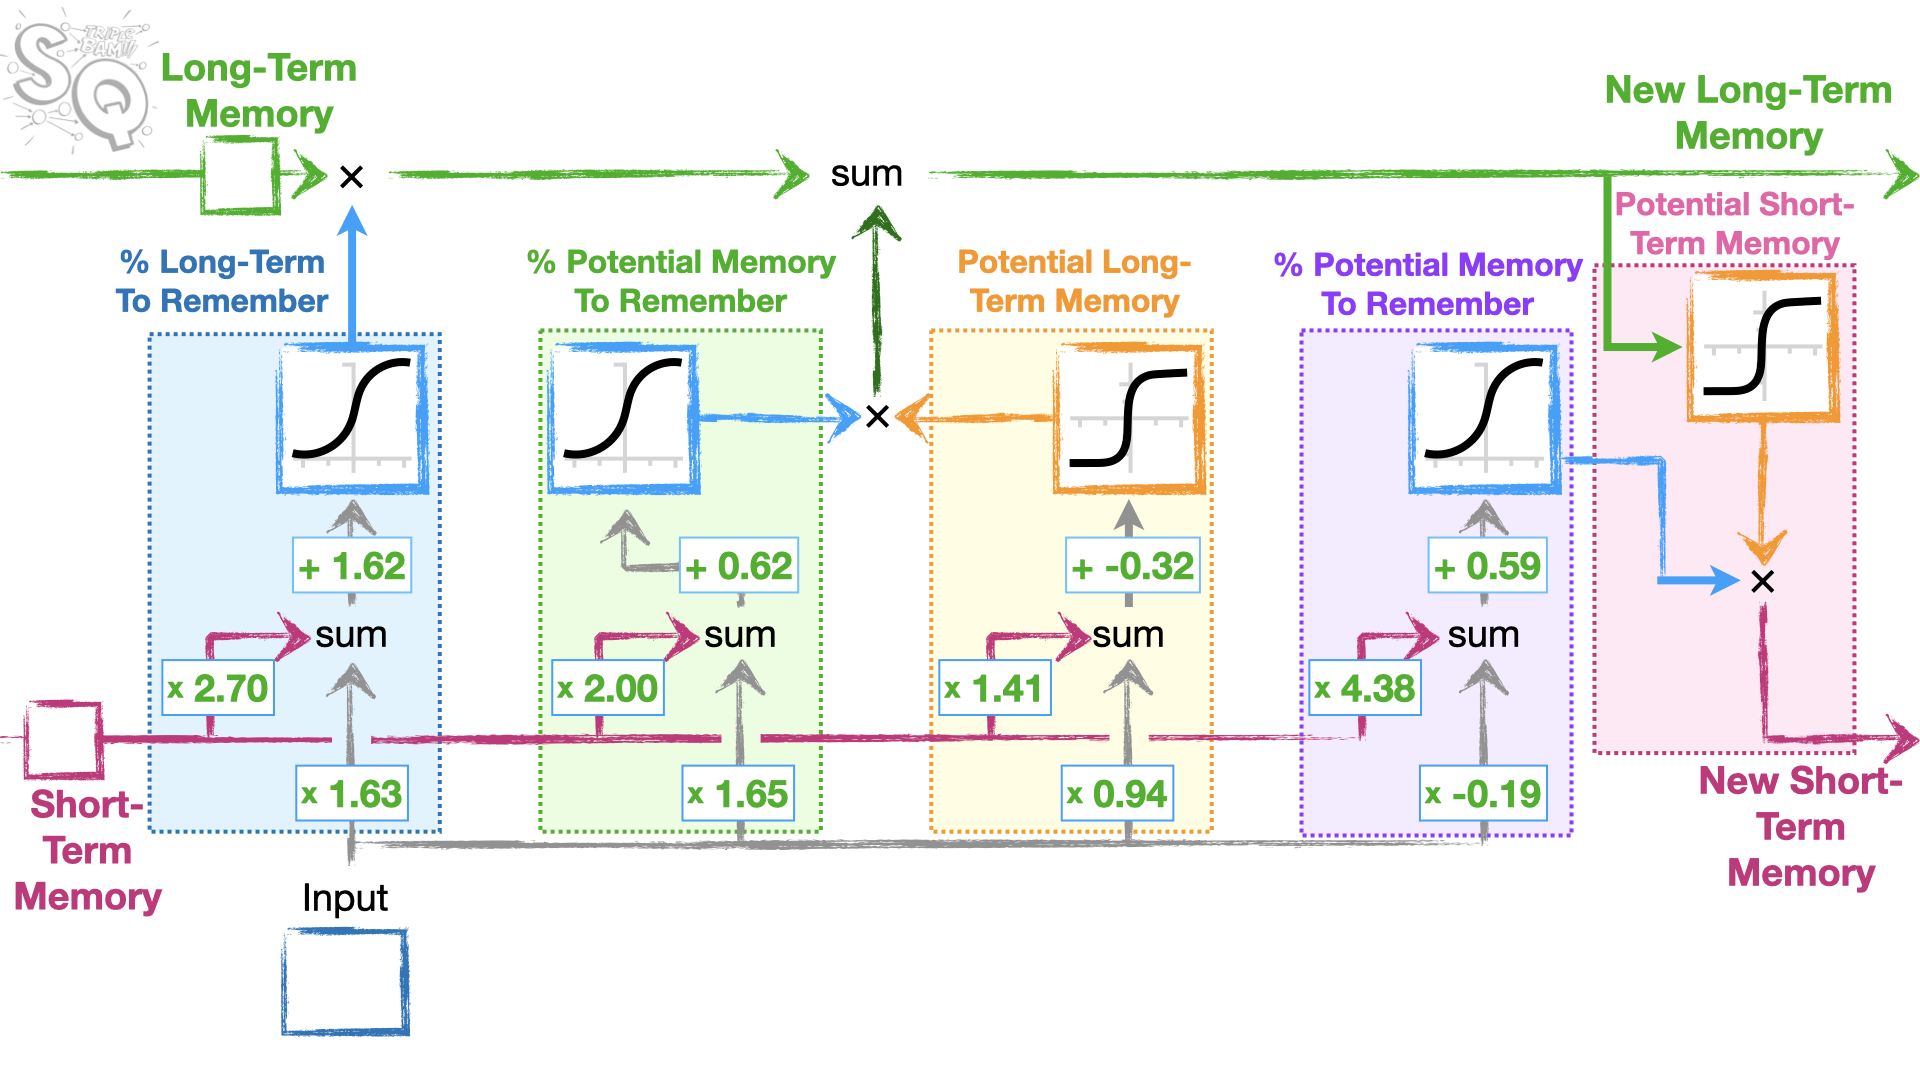

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMbyHand(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(42)  # Set the seed for reproducibility

        # Initialize weights with a normal distribution and biases as zeros.

        # Forget Gate Parameters:
        self.wlr1 = nn.Parameter(torch.randn(1))  # Weight for the previous short-term memory in the forget gate calculation.
        self.wlr2 = nn.Parameter(torch.randn(1))  # Weight for the current input in the forget gate calculation.
        self.blr1 = nn.Parameter(torch.zeros(1))  # Bias for the forget gate.

        # Input Gate Parameters:
        self.wpr1 = nn.Parameter(torch.randn(1))  # Weight for the previous short-term memory in the input gate calculation.
        self.wpr2 = nn.Parameter(torch.randn(1))  # Weight for the current input in the input gate calculation.
        self.bpr1 = nn.Parameter(torch.zeros(1))  # Bias for the input gate.

        # Candidate Memory Parameters:
        self.wp1 = nn.Parameter(torch.randn(1))   # Weight for the previous short-term memory in the candidate memory calculation.
        self.wp2 = nn.Parameter(torch.randn(1))   # Weight for the current input in the candidate memory calculation.
        self.bp1 = nn.Parameter(torch.zeros(1))   # Bias for the candidate memory.

        # Output Gate Parameters:
        self.wo1 = nn.Parameter(torch.randn(1))   # Weight for the previous short-term memory in the output gate calculation.
        self.wo2 = nn.Parameter(torch.randn(1))   # Weight for the current input in the output gate calculation.
        self.bo1 = nn.Parameter(torch.zeros(1))   # Bias for the output gate.

    def lstm_unit(self, x, long_mem, short_mem):
        # Stage 1: Determine the percentage of the current long-term memory to keep.
        long_keep = torch.sigmoid(short_mem * self.wlr1 + x * self.wlr2 + self.blr1)
        
        # Stage 2: Create new potential long-term memory and determine its contribution.
        pot_keep = torch.sigmoid(short_mem * self.wpr1 + x * self.wpr2 + self.bpr1)
        pot_mem  = torch.tanh(short_mem * self.wp1 + x * self.wp2 + self.bp1)
        new_long = long_mem * long_keep + pot_keep * pot_mem
        
        # Stage 3: Create new short-term memory based on the updated long-term memory.
        out_gate  = torch.sigmoid(short_mem * self.wo1 + x * self.wo2 + self.bo1)
        new_short = torch.tanh(new_long) * out_gate
        
        return new_long, new_short

    def forward(self, input_seq):
        # Initialize long-term and short-term memories.
        long_mem, short_mem = 0, 0
        
        # Process each element in the input sequence.
        for x in input_seq:
            long_mem, short_mem = self.lstm_unit(x, long_mem, short_mem)
        
        # Return the final short-term memory as output.
        return short_mem

# Example usage:
if __name__ == '__main__':
    model = LSTMbyHand()
    
    # Create a dummy input sequence (for example, 4 days of data).
    dummy_input = [torch.tensor([i], dtype=torch.float32) for i in range(1, 5)]
    
    # Forward pass through the model.
    output = model(dummy_input)
    print("Output:", output)
    
    # Example of setting up an optimizer and computing a simple loss.
    optimizer = optim.Adam(model.parameters())
    target = torch.tensor([0.5])
    loss = (output - target) ** 2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Output: tensor([-0.0399], grad_fn=<MulBackward0>)
